### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


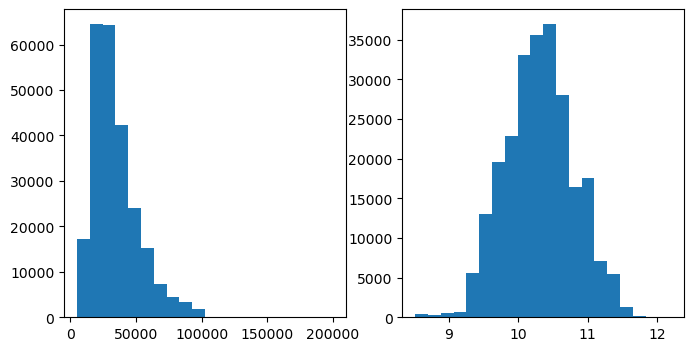

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
15485,66750798,Accounts Assistant,Accounts Assistant **** **** Hereford A Herefo...,Hereford,Hereford,NaN,permanent,NaN,Accounting & Finance Jobs,"15,000 - 20,000",17500,hays.co.uk,9.770013
241558,72678055,UK Country Manager / Sales Executive,Job Title UK Country Manager / Sales Executive...,"South East England,London,Reading,Staines,Woki...",London,NaN,permanent,Mead House,Sales Jobs,60k - 70k pa + OTE 100k + Car + Benefits,65000,jobsite.co.uk,11.082158
8078,65134317,"Chef De Partie, Cambridge Centre, Fresh Modern...","Chef De Partie, Cambridge Centre, Fresh Modern...","Cambridgeshire, UK, Cambridgeshire",Cambridgeshire,NaN,NaN,Clear Selection,Hospitality & Catering Jobs,18000 per annum,18000,jobs.catererandhotelkeeper.com,9.798182


In [6]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()
for text_column in text_columns:
    print(text_column)
    data[text_column] = [' '.join(tokenizer.tokenize(str(full_description).lower())) for full_description in data[text_column]]

Title
FullDescription


In [7]:
from collections import Counter
from tqdm import tqdm, trange
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
for text_column in text_columns:
    for text in tqdm(data[text_column], "Iterating through data rows"):
        for token in text.split():
            token_counts[token] += 1

Iterating through data rows: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 244768/244768 [00:10<00:00, 24168.24it/s]


In [8]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)#TODO<YOUR CODE HERE>

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [9]:
token_to_id = dict() # <your code here - dict of token name to its index in tokens>
for i in trange(len(tokens)):
    token_to_id[tokens[i]] = i

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34158/34158 [00:00<00:00, 1763181.01it/s]


In [10]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [11]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [12]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [14]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[27645, 29893, 33674,     1,     1,     1,     1],
         [29239,   197, 19175, 20042, 15554, 23162,  4051],
         [10609, 30412, 17746,    33,  8705, 29157,    65]]),
 'FullDescription': tensor([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451, 32939],
         [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,    82],
         [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412, 17746]]),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144])}

In [15]:
class TextEncoder(nn.Module):
    def __init__(self, hid_size=64):
        super().__init__()
        self.emb = torch.nn.Embedding(len(tokens), 32)
        self.conv = torch.nn.Conv1d(32, hid_size, kernel_size=3, )

    def forward(self, idx):
        embs = self.emb(idx)
        embs = embs.transpose(2, 1)
        conv_outs = self.conv(embs)
        max_pool = torch.max(conv_outs, dim=-1).values
        return max_pool
    
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.title_enc = TextEncoder(hid_size=hid_size)
        self.descr_enc = TextEncoder(hid_size=hid_size)
        self.title_enc.emb = self.descr_enc.emb
        self.categ_enc = nn.Linear(n_cat_features, hid_size)
        self.output = nn.Linear(hid_size * 3, 1)
        
        
    def forward(self, batch):
        title = self.title_enc.forward(batch["Title"])
        descr = self.descr_enc.forward(batch["FullDescription"])
        categ = self.categ_enc.forward(batch["Categorical"])
        
        concat = torch.concat((title.T, descr.T, categ.T)).T
        return self.output.forward(concat).flatten()

In [16]:
model = SalaryPredictor()

In [17]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

In [18]:
from tqdm.auto import tqdm

BATCH_SIZE = 32
EPOCHS = 1

In [19]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [20]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val, device=device)

      

epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.23696
Mean absolute error: 0.39767


In [30]:
test_batch = make_batch(data_val[:3], max_len=10)
test_pred = model(test_batch)
print(f"test_pred = {test_pred.detach().cpu().numpy()}")
print(f"test_true = {data_val['Log1pSalary'][:3].values}")

test_pred = [5.495172  5.9892273 7.39333  ]
test_true = [10.064798  10.045031  10.4588375]


In [31]:
class SalaryPredictorExtraLayers(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64, hid_size_2 = 32):
        super().__init__()
        self.title_enc = TextEncoder(hid_size=hid_size)
        self.descr_enc = TextEncoder(hid_size=hid_size)
        self.title_enc.emb = self.descr_enc.emb
        self.categ_enc = nn.Linear(n_cat_features, hid_size)
        self.linear = nn.Linear(hid_size * 3, hid_size_2)
        self.output = nn.Linear(hid_size_2, 1)
        
        
    def forward(self, batch):
        title = self.title_enc.forward(batch["Title"])
        descr = self.descr_enc.forward(batch["FullDescription"])
        categ = self.categ_enc.forward(batch["Categorical"])
        
        concat = torch.concat((title.T, descr.T, categ.T)).T
        linear_result = self.linear.forward(concat)
        return self.output.forward(linear_result).flatten()

In [32]:
model = SalaryPredictorExtraLayers().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val, device=device)

epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.19252
Mean absolute error: 0.35146


In [45]:
class TextEncoderFewConvs(nn.Module):
    def __init__(self, hid_size=32):
        super().__init__()
        self.emb = torch.nn.Embedding(len(tokens), 32)
        self.conv1 = torch.nn.Conv1d(32, hid_size, kernel_size=3, )
        self.conv2 = torch.nn.Conv1d(32, hid_size, kernel_size=3, )

    def forward(self, idx):
        embs = self.emb(idx)
        embs = embs.transpose(2, 1)
        conv1_outs = self.conv1(embs)
        conv2_outs = self.conv2(embs)
        max_pool1 = torch.max(conv1_outs, dim=-1).values
        max_pool2 = torch.max(conv2_outs, dim=-1).values
        return torch.concat((max_pool1.T, max_pool2.T)).T

In [46]:
batch = make_batch(data_train[:3], max_len=10)
enc = TextEncoderFewConvs()
enc.forward(batch["Title"]).shape

torch.Size([3, 64])

In [47]:
class SalaryPredictorExtraLayersWithNewTextEncoders(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64, hid_size_2 = 32):
        super().__init__()
        self.title_enc = TextEncoderFewConvs(hid_size=hid_size // 2)
        self.descr_enc = TextEncoderFewConvs(hid_size=hid_size // 2)
        self.title_enc.emb = self.descr_enc.emb
        self.categ_enc = nn.Linear(n_cat_features, hid_size)
        self.linear = nn.Linear(hid_size * 3, hid_size_2)
        self.output = nn.Linear(hid_size_2, 1)
        
        
    def forward(self, batch):
        title = self.title_enc.forward(batch["Title"])
        descr = self.descr_enc.forward(batch["FullDescription"])
        categ = self.categ_enc.forward(batch["Categorical"])
        
        concat = torch.concat((title.T, descr.T, categ.T)).T
        linear_result = self.linear.forward(concat)
        return self.output.forward(linear_result).flatten()

In [48]:
model = SalaryPredictorExtraLayersWithNewTextEncoders().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val, device=device)

epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.17977
Mean absolute error: 0.33695


In [82]:
class TextEncoderDifferentPullings(nn.Module):
    def __init__(self, hid_size=32):
        super().__init__()
        self.emb = torch.nn.Embedding(len(tokens), 32)
        self.conv = torch.nn.Conv1d(32, hid_size, kernel_size=3, )

    def forward(self, idx):
        embs = self.emb(idx)
        embs = embs.transpose(2, 1)
        conv_outs = self.conv(embs)
        max_pool = torch.max(conv_outs, dim=-1).values
        min_pool = torch.min(conv_outs, dim=-1).values
        return torch.concat((max_pool.T, min_pool.T)).T

In [83]:
batch = make_batch(data_train[:3], max_len=10)
enc = TextEncoderDifferentPullings()
enc.forward(batch["Title"]).shape

torch.Size([3, 64])

In [86]:
class SalaryPredictorExtraLayersWithNew2TextEncoders(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64, hid_size_2 = 32):
        super().__init__()
        self.title_enc = TextEncoderDifferentPullings(hid_size=hid_size // 2)
        self.descr_enc = TextEncoderDifferentPullings(hid_size=hid_size // 2)
        self.title_enc.emb = self.descr_enc.emb
        self.categ_enc = nn.Linear(n_cat_features, hid_size)
        self.linear = nn.Linear(hid_size * 3, hid_size_2)
        self.output = nn.Linear(hid_size_2, 1)
        
        
    def forward(self, batch):
        title = self.title_enc.forward(batch["Title"])
        descr = self.descr_enc.forward(batch["FullDescription"])
        categ = self.categ_enc.forward(batch["Categorical"])
        
        concat = torch.concat((title.T, descr.T, categ.T)).T
        linear_result = self.linear.forward(concat)
        return self.output.forward(linear_result).flatten()

In [87]:
model = SalaryPredictorExtraLayersWithNew2TextEncoders().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val, device=device)

epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.15767
Mean absolute error: 0.30526


### A short report

Please tell us what you did and how did it work.

Baseline learned for 5 epochs gives a `MSE = 0.115, MAE = 0.265`

For reducing learning time lets learn only 1 epoch. (I think results can be scaled to N epochs with approximately same effects)

Baseline losses on 1 epoch are `MSE = 0.237, MAE = 0.398`

Let's view how CNN architecture will affect losses.

So, extra linear layer with hidden_size 32 gives us a significant boost: `MSE = 0.193, MAE = 0.351`.

Parallel convolution layers gives us a visible boost as well: `MSE = 0.180, MAE = 0.337` (comparing to previous model).


Now let's rollback to just extra layer and try to play with pullings. Now we will make max & min pullings.

We have incredible results: `MSE = 0.158, MAE = 0.305`.

Now let's use early stopping to learn out model well. Source: https://pythonguides.com/pytorch-early-stopping/

Could not debut it :(

In [50]:
import os

import torch
from pytorch_lightning import LightningModule, Trainer
from torch import nn
from torch.nn import functional as f
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

PATHDATASET = os.environ.get("PATH_DATASETS", ".")
AVAILGPUS = min(1, torch.cuda.device_count())
BATCHSIZE = 250 if AVAILGPUS else 60
    
class SalaryPredictorExtraLayersWithNewTextEncodersLightning(LightningModule):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64, hid_size_2 = 32):
        super().__init__()
        self.title_enc = TextEncoderFewConvs(hid_size=hid_size // 2)
        self.descr_enc = TextEncoderFewConvs(hid_size=hid_size // 2)
        self.title_enc.emb = self.descr_enc.emb
        self.categ_enc = nn.Linear(n_cat_features, hid_size)
        self.linear = nn.Linear(hid_size * 3, hid_size_2)
        self.output = nn.Linear(hid_size_2, 1)
        self.criterion = nn.MSELoss(reduction='sum')
        
        
    def forward(self, batch):
        title = self.title_enc.forward(batch["Title"])
        descr = self.descr_enc.forward(batch["FullDescription"])
        categ = self.categ_enc.forward(batch["Categorical"])
        
        concat = torch.concat((title.T, descr.T, categ.T)).T
        linear_result = self.linear.forward(concat)
        return self.output.forward(linear_result).flatten()
    
    def training_step(self, batch, batch_nb):
        X, y = batch
        loss = self.criterion(self(X), y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [55]:
# Init our model
mnistmodel = model = SalaryPredictorExtraLayersWithNewTextEncodersLightning()

# Init DataLoader from MNIST Dataset
traindataset = MNIST(".", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(traindataset, batch_size=BATCHSIZE)

# Initialize a trainer
trainer = Trainer(
    max_epochs=3,
#     progress_bar_refresh_rate=20,
)

# Train the model 
trainer.fit(mnistmodel, train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type                | Params
--------------------------------------------------
0 | title_enc | TextEncoderFewConvs | 1.1 M 
1 | descr_enc | TextEncoderFewConvs | 1.1 M 
2 | categ_enc | Linear              | 241 K 
3 | linear    | Linear              | 6.2 K 
4 | output    | Linear              | 33    
5 | criterion | MSELoss             | 0     
--------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.412     Total estimated model params size (MB)
/Users/nvdenisov2002/miniconda3/envs/shad/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` 

Training: 0it [00:00, ?it/s]

IndexError: too many indices for tensor of dimension 4

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!